# Produce dirty image and psf, from a (rascil) FITS image, and an instrumental setup (baselines, frequencies, etc.)

In [1]:
from visibilities import *
from images import *
import matplotlib.pyplot as plt
import matplotlib
import numpy
import helpers

plt.set_loglevel("critical")
cmap='turbo'
matplotlib.rcParams['figure.figsize'] = [5, 5]

export_datasets = False

### Define baseline configuration, integration time, hour angle interval of observations, phase centre, etc.

In [2]:
phasecentre = SkyCoord(ra=+56.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
ha_interval=(-2,2)
vt = generate_visibilities(phasecentre,ha_interval,tel="MEERKAT", integration_time=120, frequencies=np.array([1.e9]))
gt_name = "SGRA"

create_named_configuration: MEERKAT
	(<Quantity 5109360.08350152 m>, <Quantity 2006852.56658911 m>, <Quantity -3238948.21751511 m>)
	GeodeticLocation(lon=<Longitude 21.44388889 deg>, lat=<Latitude -30.7110565 deg>, height=<Quantity 1086.6 m>)
create_configuration_from_file: 64 antennas/stations
create_visibility: created 120 times
create_visibility: 249600 rows, 0.013 GB


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


### Plot uv coverage


There is no flagged visibility. Skip plotting flagged.


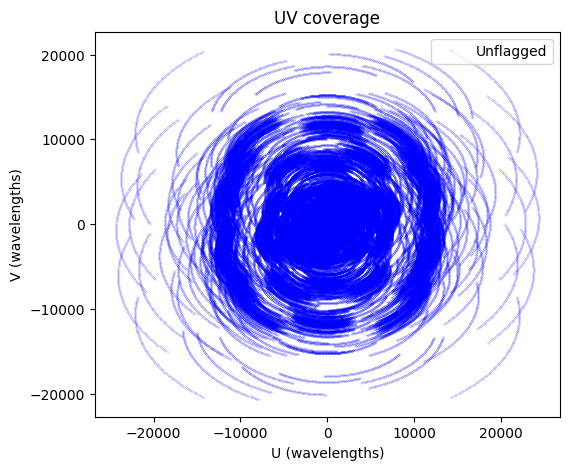

In [3]:
matplotlib.rcParams['figure.figsize'] = [6, 5]
plot_uvcoverage([vt])


advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10775.0 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
advise_wide_field: (cellsize) Cellsize 1.03e-05 (rad) 0.000589 (deg) 2.12 (asec)
advice_wide_field: (npixels) Npixels per side = 6484
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 6561

advice_wide_field: (w_sa

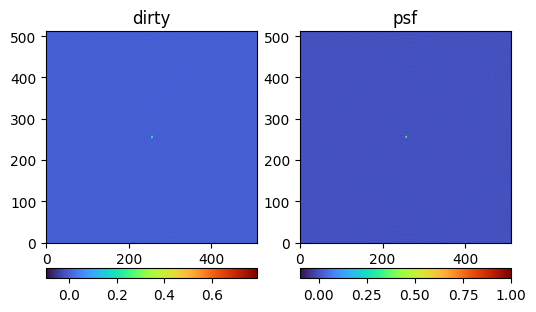

In [8]:
vt, cell_size, im = visibilities_from_image(vt,'../data/shifted_dirac_ext.fits',return_cellsize=True,return_image=True,scale_factor=1.8)
dirty, psf = dirty_psf_from_visibilities(vt,cell_size,npix=512,weighting="uniform")

helpers.plotNImages([dirty.pixels.data[0,0,:,:], psf.pixels.data[0,0,:,:]], ["dirty", "psf"], cmap=cmap)

helpers.write_nparr_to_fits(dirty.pixels.data[0,0,:,:], "../data/test_dirac_dirty.fits")
helpers.write_nparr_to_fits(psf.pixels.data[0,0,:,:], "../data/test_dirac_psf.fits")

### Fill visibilities amplitude from (Fourier plane values) of image in FITS file. Cell size corresponds to the (advised) pixel angular size in radians. Uses Nifty gridder.

In [4]:
vt, cell_size, im = visibilities_from_image(vt,'../data/' + gt_name + '_full_gt.fits',return_cellsize=True,return_image=True,scale_factor=1.8)
stdv_real = numpy.std(numpy.array(vt.vis.real).flatten())
stdv_imag = numpy.std(numpy.array(vt.vis.imag).flatten())

print(stdv_real)
print(stdv_imag)
print(cell_size)

stdv_real /= 50
stdv_imag /= 50

noise_real = numpy.random.normal(loc=0, scale=stdv_real, size=vt.vis.shape)
noise_imag = numpy.random.normal(loc=0, scale=stdv_imag, size=vt.vis.shape) 

noise = numpy.vectorize(complex)(noise_real, noise_imag)
vis_with_noise = vt.vis + noise
vt["vis"].data = vis_with_noise
#vt, cell_size, im = visibilities_from_image(vt,'data/toto_ext.fits',return_cellsize=True,return_image=True,scale_factor=1.)

advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10775.0 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
advise_wide_field: (cellsize) Cellsize 1.03e-05 (rad) 0.000589 (deg) 2.12 (asec)
advice_wide_field: (npixels) Npixels per side = 6484
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 6561

advice_wide_field: (w_sa

### Export visibility data to measurement set file

In [5]:
from rascil.processing_components import export_visibility_to_ms
if export_datasets:
    export_visibility_to_ms('../data6/' + gt_name + '_serial.ms',[vt])

### Convert radius of uv hole from lambda to pixels

In [6]:
radius = 7000
delta_radius = 1000
npixels = 512
radius_pixel = radius * cell_size * npixels
delta_radius_pixel = delta_radius * cell_size * npixels
print(cell_size)
print("uvmin_lambda,uvmax_lambda = %d,%d"%(radius-delta_radius/2,radius+delta_radius/2))
print("uvmin_pix,uvmax_pix,npix = %d,%d,%d"%(radius_pixel-delta_radius_pixel/2, 
                                             radius_pixel+delta_radius_pixel/2, npixels))

1.8494516688531545e-05
uvmin_lambda,uvmax_lambda = 6500,7500
uvmin_pix,uvmax_pix,npix = 61,71,512


### Load short and long baseline measurement sets, plot uv coverage

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 118941 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746
create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 169477 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_

/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


(120, 2080, 1, 1)
(120, 2080, 1, 1)
There is no flagged visibility. Skip plotting flagged.


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


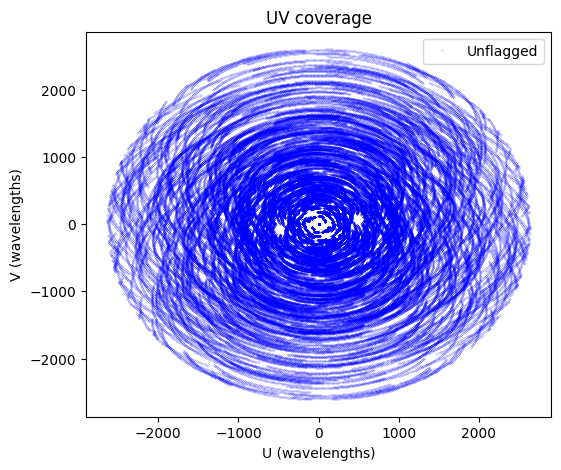

There is no flagged visibility. Skip plotting flagged.


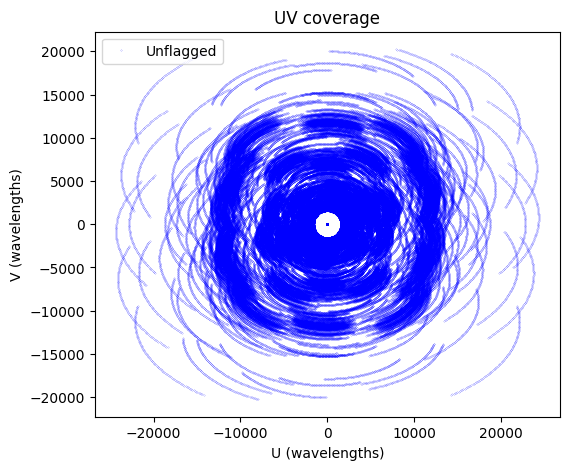

In [7]:
from rascil.processing_components import create_visibility_from_ms

delta = 5
ell = 20

[vs] = create_visibility_from_ms('../data4/' + gt_name + '_small_baselines_' + str(ell + delta) + '.ms')
[vl] = create_visibility_from_ms('../data4/' + gt_name + '_long_baselines_' + str(ell - delta) + '.ms')
print(vs.visibility_acc.flagged_weight.shape)
print(vl.vis.shape)
plot_uvcoverage([vs])
plot_uvcoverage([vl])


### Plot visibility amplitudes as a function of uv radius

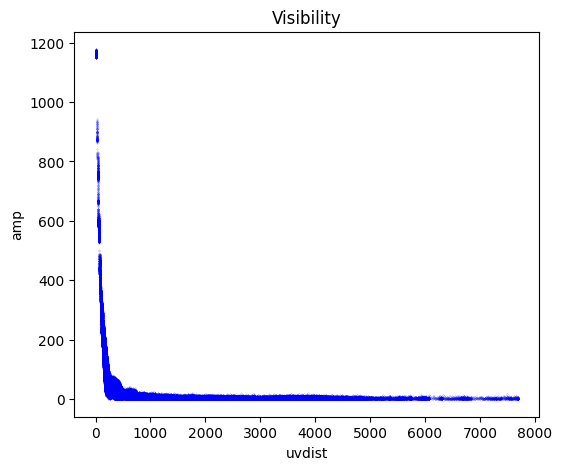

122.50670586143382
1.1600395857977923


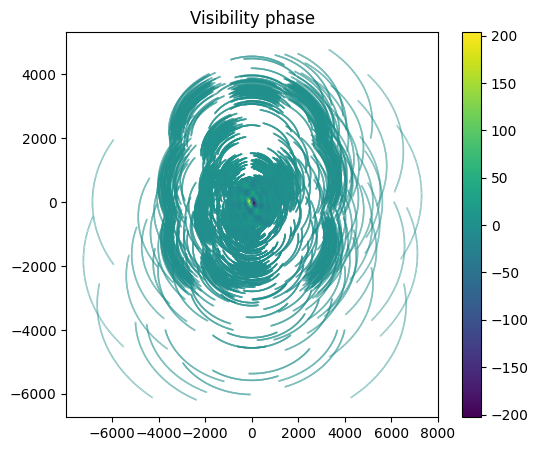

In [8]:
#vv = np.ones(vt.vis.shape)
#vt["vis"].data = vv
import math
plot_visibility([vt])
u = vt.visibility_acc.u.data
v = vt.visibility_acc.v.data
c = numpy.imag(vt.vis.data)

max_dist = 0

uv=vt.visibility_acc.uvw_lambda[...,0:2]
nrows,nbaselines, _ = vt.uvw.shape
uv = uv.reshape(nrows*nbaselines,2)

for i, uval in enumerate(uv[0]):
    dist = math.sqrt(uv[0,i] * uv[0,i] + uv[1,i] * uv[1,i])
    max_dist = max(dist, max_dist)

print(max_dist)
print(max_dist * cell_size * 512)

plt.title('Visibility phase')
plt.scatter(u,v,c=c,marker='.', s=0.1)
plt.colorbar()


### Create empty (rascil) image from visibility metadata. Then predict dirty and psf images using nifty gridder (adjoint)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -35.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


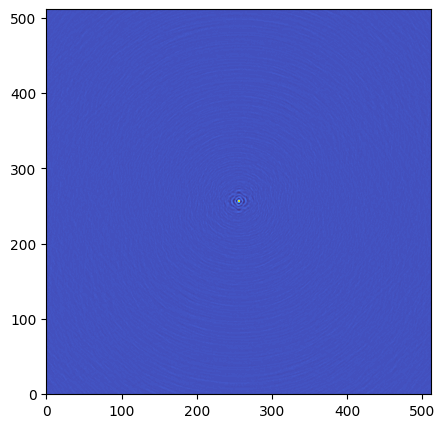

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 2638.861081 wavelengths
create_image_from_visibility: Critical cellsize = 0.000189 radians, 0.010856 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_

In [9]:
dirty, psf = dirty_psf_from_visibilities(vt,cell_size,npix=512,weighting="uniform")
helpers.plotNImages([psf.pixels.data[0, 0,:,:]], [""], cmap=cmap)
dirty_short, psf_short = dirty_psf_from_visibilities(vs,cell_size,npix=512,weighting="uniform")
dirty_long, psf_long = dirty_psf_from_visibilities(vl,cell_size,npix=512,weighting="uniform")

### Visualize original image, dirty image and psf

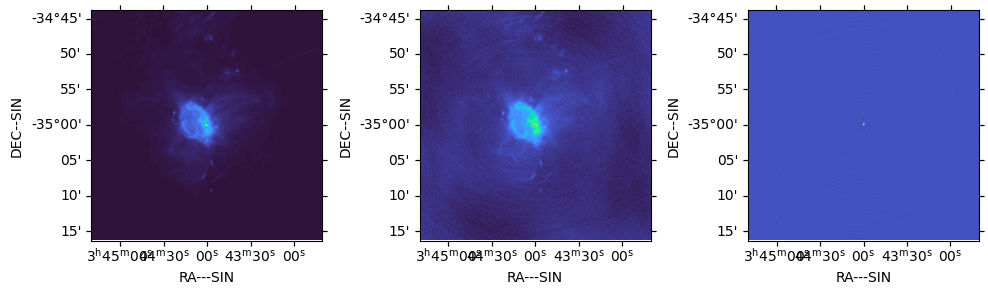

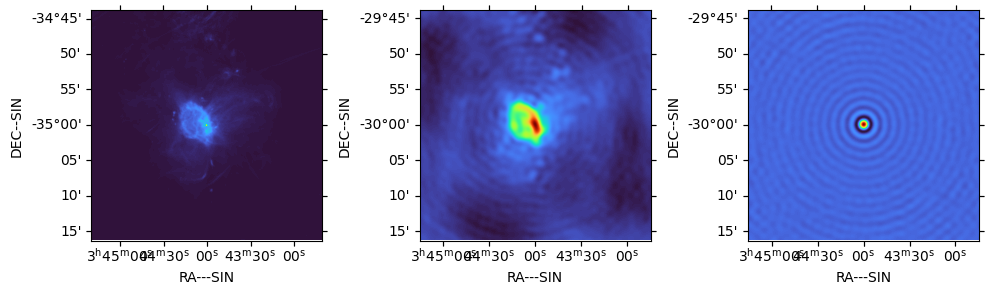

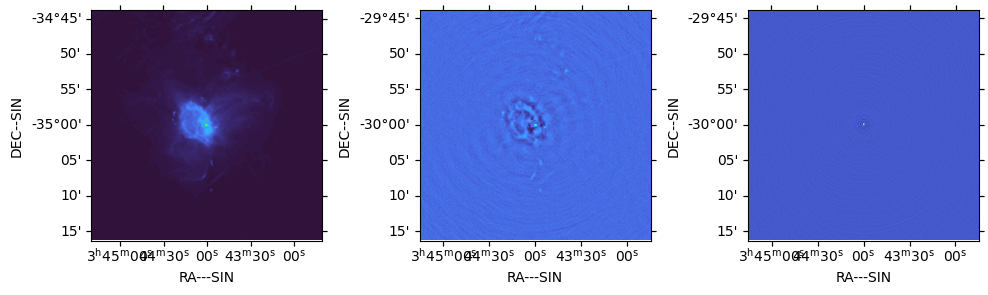

In [10]:
#show_image(im,cm=cmap)
#show_image(dirty,cm=cmap)
#show_image(psf,cm=cmap)
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf.image_acc.wcs.sub([1, 2]))
ax.imshow(psf.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf.image_acc.wcs.wcs.ctype[1])

# Now for short baselines only
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty_short.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty_short.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty_short.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty_short.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf_short.image_acc.wcs.sub([1, 2]))
ax.imshow(psf_short.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf_short.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf_short.image_acc.wcs.wcs.ctype[1])

# Now for long baselines only
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty_long.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty_long.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty_long.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty_long.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf_long.image_acc.wcs.sub([1, 2]))
ax.imshow(psf_long.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf_long.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf_long.image_acc.wcs.wcs.ctype[1])


### Export dirty, psf to fits

In [11]:
# Export dirty, psf
dirty.image_acc.export_to_fits('../data/' + gt_name + '_dirty.fits')
psf.image_acc.export_to_fits('../data/'  + gt_name + '_psf.fits')
dirty_short.image_acc.export_to_fits('../data/'  + gt_name + '_noiseless_' + str(ell + delta) + '_dirty.fits')
psf_short.image_acc.export_to_fits('../data/' + gt_name + '_noiseless_' + str(ell + delta) + '_psf.fits')
dirty_long.image_acc.export_to_fits('../data/' + gt_name + '_noiseless_' + str(ell - delta) + '_dirty.fits')
psf_long.image_acc.export_to_fits('../data/' + gt_name + '_noiseless_' + str(ell - delta) + '_psf.fits')


(-0.05, 1.0)

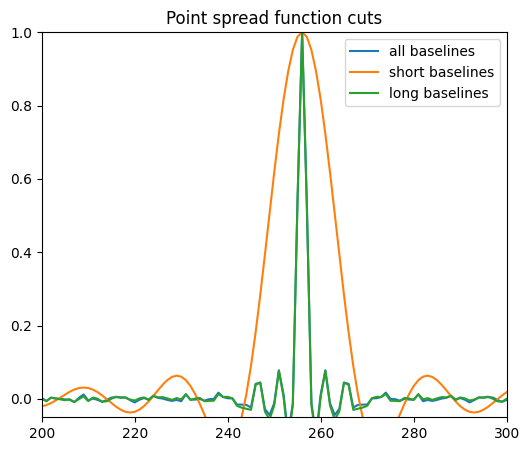

In [12]:
plt.plot(psf['pixels'].data[0,0,256,:],label='all baselines')
plt.plot(psf_short['pixels'].data[0,0,256,:],label='short baselines')
plt.plot(psf_long['pixels'].data[0,0,256,:],label='long baselines')
plt.legend()
plt.title('Point spread function cuts')
plt.xlim((200,300)); plt.ylim((-0.05,1))

0.18190324473380343


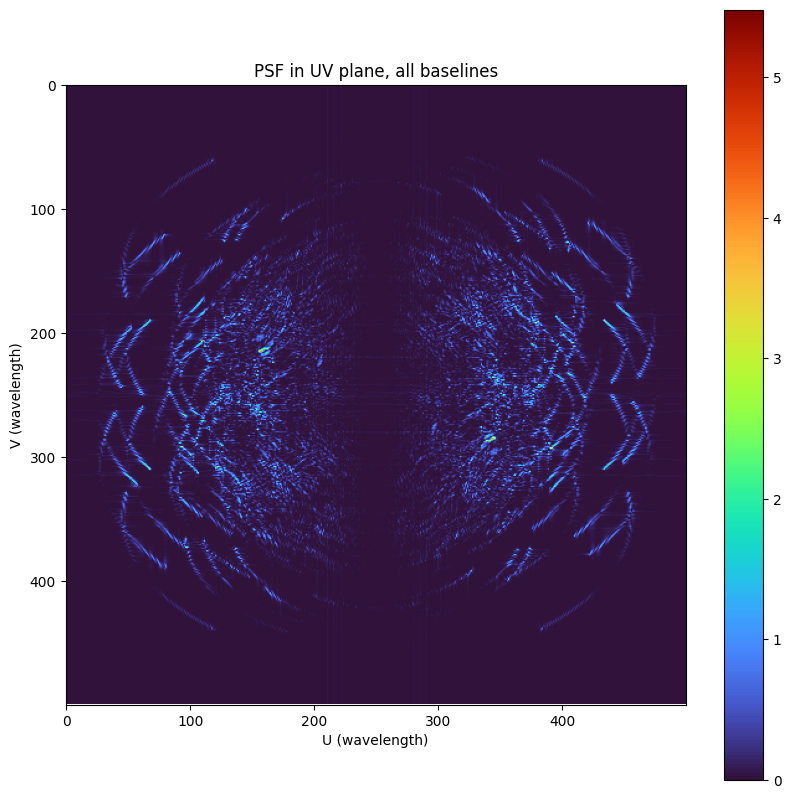

In [13]:
#psf.pixels.data[0,0,0,:] = 0
#psf.pixels.data[0,0,:,0] = 0
#print(psf.pixels.data[0,0,0,:])
#print(psf.pixels.data[0,0,:,0])
c = int(512/2)
uv_psf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf.pixels.data[0,0,c-250:c+250,c-250:c+250])))

print(np.max(np.imag(uv_psf)) / np.max(np.real(uv_psf)))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
matplotlib.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.imag(uv_psf)**2, cmap=cmap)
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.title('PSF in UV plane, all baselines')
plt.colorbar()

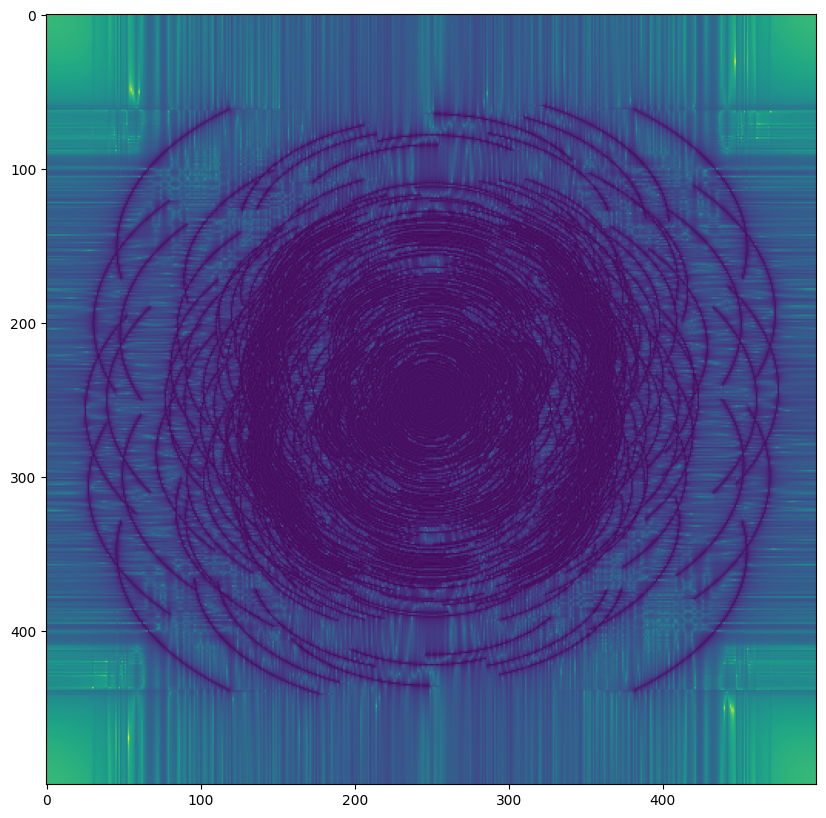

In [14]:
uv_psf = 1 / uv_psf
plt.imshow(np.power(np.abs(uv_psf), 0.1))

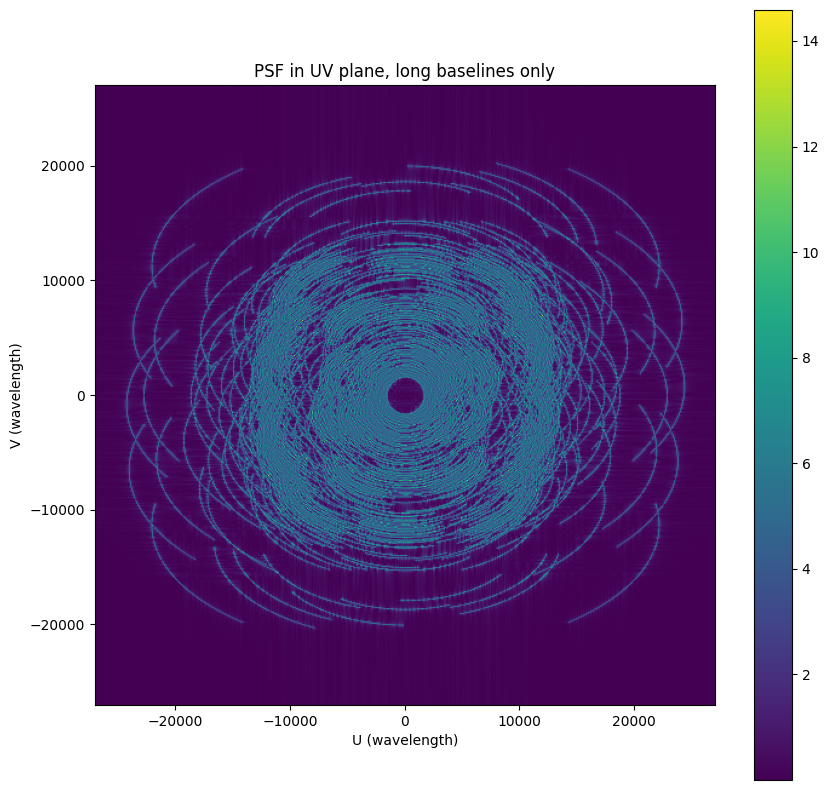

In [15]:
uv_psf_long = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf_long.pixels.data.squeeze())))
#uv_psf_long[np.abs(uv_psf_long) > 0.01] = 1
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf_long),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.title('PSF in UV plane, long baselines only')
plt.colorbar()

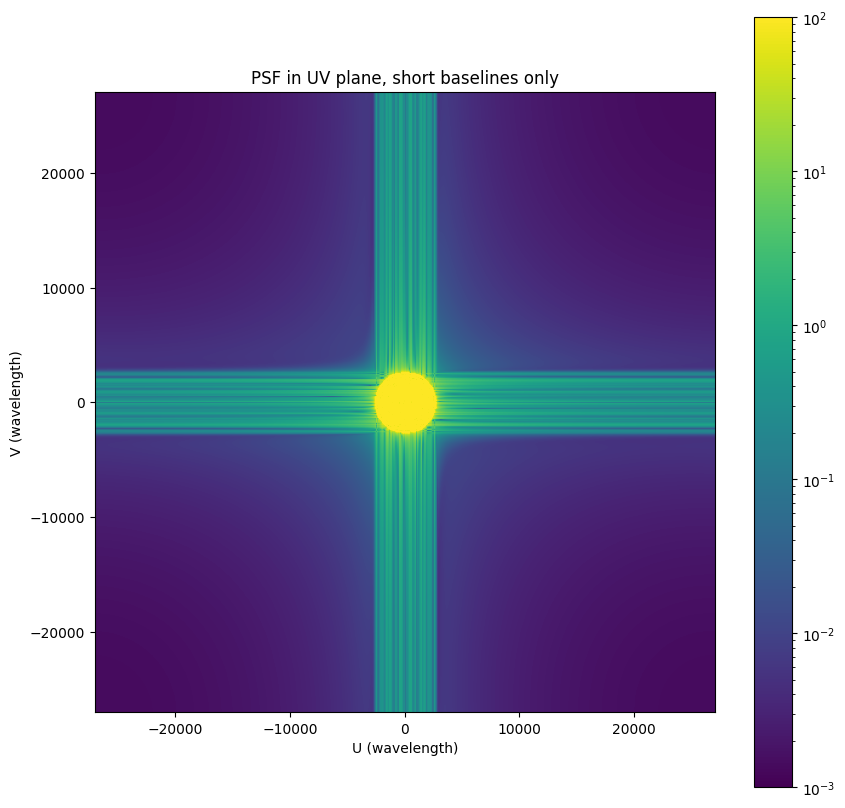

In [16]:
uv_psf_short = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf_short.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf_short),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.title('PSF in UV plane, short baselines only')
plt.colorbar()

In [17]:
#from astropy.io import fits as pyfits
#hdu = pyfits.PrimaryHDU(np.real(uv_psf))
#hdu.writeto("uv_psf.fits",overwrite=True)

In [18]:
nrows,nbaselines, _ = vt.uvw.shape

In [19]:
uv=vt.visibility_acc.uvw_lambda[...,0:2]
uv = uv.reshape(nrows*nbaselines,2)

In [20]:
uv.shape

(249600, 2)

In [21]:
from scipy.spatial import KDTree
tree = KDTree(uv)
neighbors = tree.query_ball_tree(tree,r=100)

In [22]:
# weights = 1./np.array([len(l) for l in neighbors])
# weights /= np.sum(weights)
# weights = weights.reshape(nrows,nbaselines,1,1)
# vt.imaging_weight.data = weights
vt = compute_weights(vt, 512, cell_size, 'natural')
weights = vt.visibility_acc.flagged_weight.reshape(
        [nrows * nbaselines, 1]
    )
print(weights.shape)

(249600, 1)


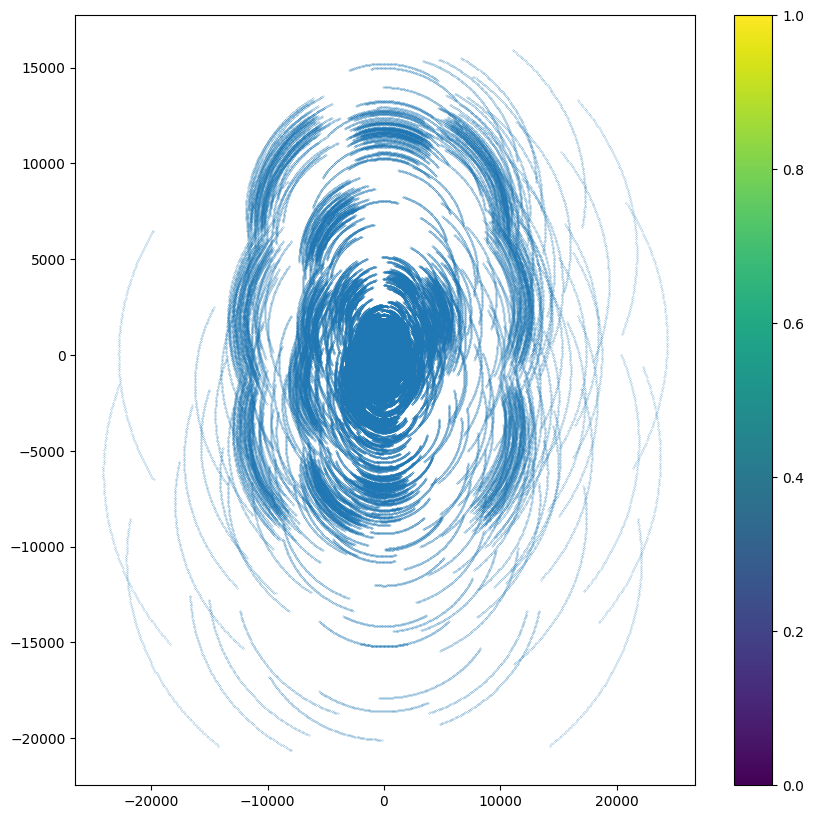

In [23]:
plt.scatter(uv[:,0],uv[:,1],marker='.', s=0.1)
#plt.scatter(-uv[:,0],-uv[:,1],c=weights,marker='.', s=0.1)
plt.colorbar()

### w-values of visibilities

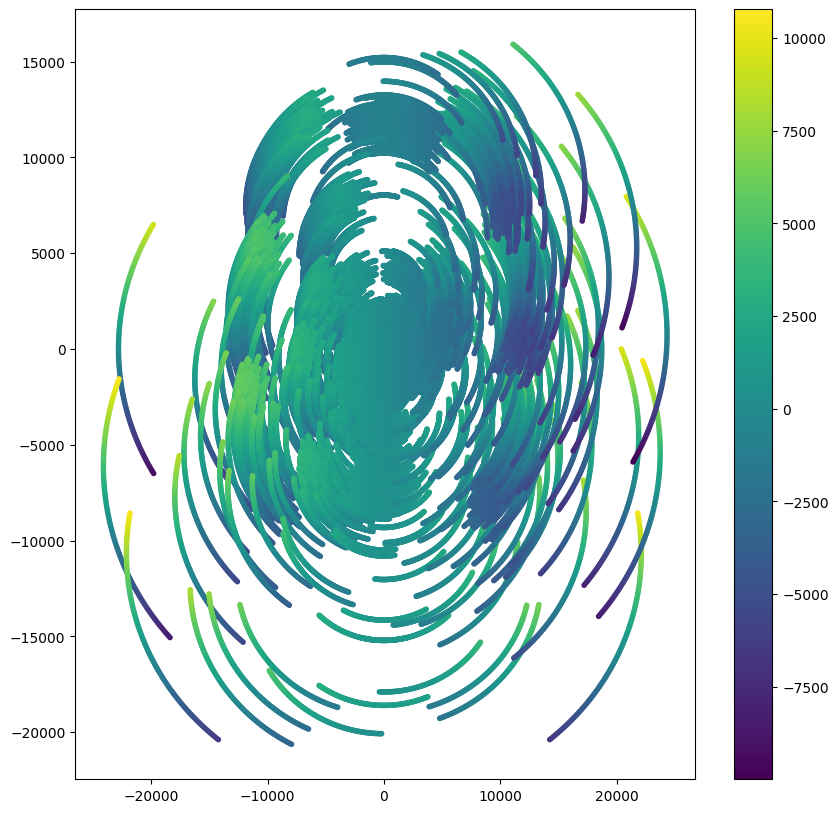

In [24]:
from pprint import pprint
w = vt.visibility_acc._uvw_lambda[:,:,:,2]
w = w.flatten()

plt.scatter(uv[:,0],uv[:,1],c=w,marker='.')
plt.colorbar()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 2638.861081 wavelengths
create_image_from_visibility: Critical cellsize = 0.000189 radians, 0.010856 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


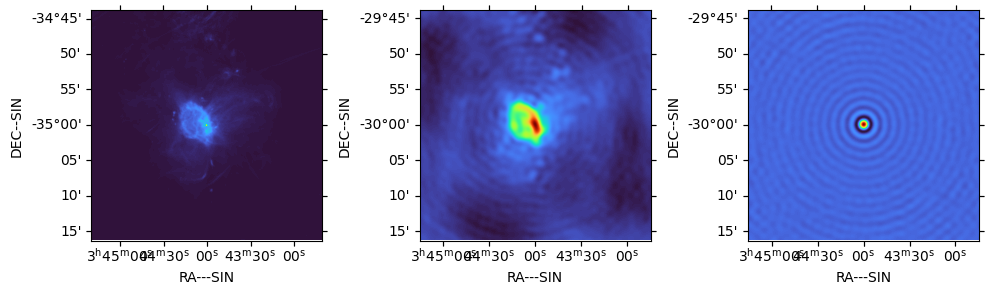

In [25]:

dirty, psf = dirty_psf_from_visibilities(vs,cell_size,npix=512)
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf.image_acc.wcs.sub([1, 2]))
ax.imshow(psf.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf.image_acc.wcs.wcs.ctype[1])


(-0.1, 1.0)

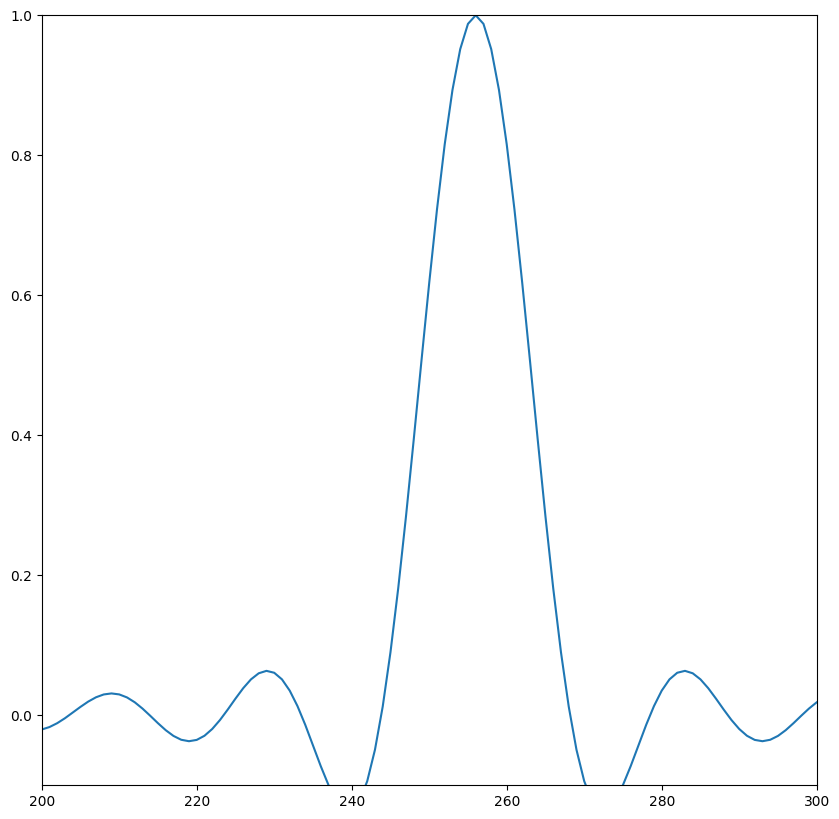

In [26]:
plt.plot(psf['pixels'].data[0,0,256,:])
plt.xlim((200,300)); plt.ylim((-0.1,1))

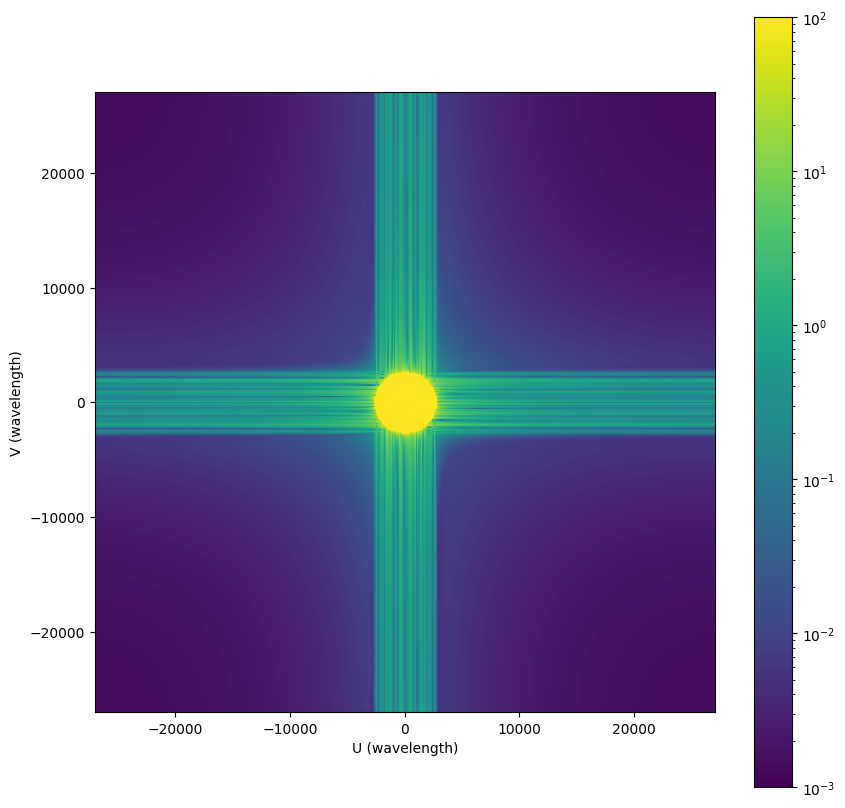

In [27]:
uv_psf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.colorbar()

In [28]:
1./cell_size / 256 * 50

10560.562532629649

## Ground truth images of three datasets

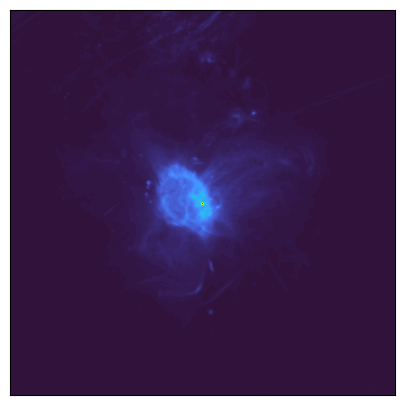

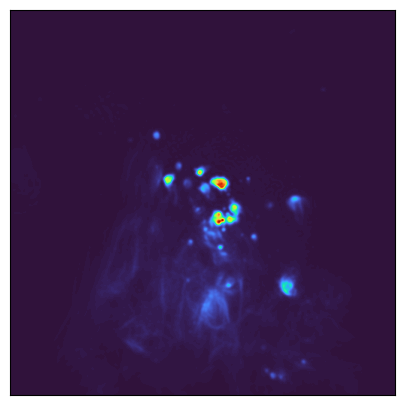

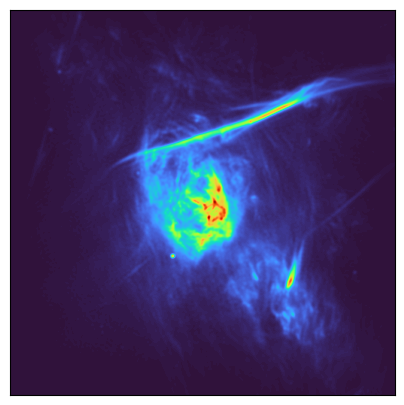

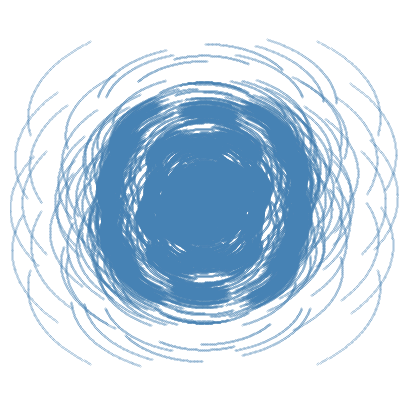

In [29]:
matplotlib.rcParams['figure.figsize'] = [5, 5]

agt = helpers.readFits("../data/SGRA_full_gt.fits")
bgt = helpers.readFits("../data/SGRB_full_gt.fits")
cgt = helpers.readFits("../data/SGRC_full_gt.fits")

helpers.plotNImages([agt], [""], cmap, output_file="../figures/SGRA_full_gt.png", hide_ticks=True)
helpers.plotNImages([bgt], [""], cmap, output_file="../figures/SGRB_full_gt.png", hide_ticks=True)
helpers.plotNImages([cgt], [""], cmap, output_file="../figures/SGRC_full_gt.png", hide_ticks=True)

plt.show()

u = vt.visibility_acc.u.data
v = vt.visibility_acc.v.data
c = [1]*u.size

matplotlib.rcParams['figure.figsize'] = [5, 5]

max_xy = numpy.max([numpy.max(numpy.fabs(u)), numpy.max(numpy.fabs(v))])
plt.scatter(u,v,marker='.', s=0.1, c='steelblue')
plt.scatter(-u,-v,marker='.', s=0.1, c='steelblue')
plt.xlim([-max_xy, max_xy])
plt.ylim([-max_xy, max_xy])

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig("../figures/uv_coverage.png", pad_inches=0.0, bbox_inches='tight')


In [30]:
from rascil.processing_components import create_visibility_from_ms

[vispriyam] = create_visibility_from_ms('~/priyams_shit/example.ms')

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 156024 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 16:06:07.727 to 2000-01-01 23:06:07.727


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


In [31]:
pdirty, ppsf = dirty_psf_from_visibilities(vispriyam,7.27221e-7,npix=128,weighting="uniform")
wscleanpsf = helpers.readFits("~/priyams_shit/wsclean-psf.fits")
wscleandirty = helpers.readFits("~/priyams_shit/wsclean-dirty.fits")

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1400000000.0 Hz, and bandwidth 420000000.0 Hz
create_image_from_visibility: uvmax = 721442.404537 wavelengths
create_image_from_visibility: Critical cellsize = 0.000001 radians, 0.000040 degrees
create_image_from_visibility: Cellsize = 7.27221e-07 radians, 4.16667e-05 degrees
create_image_from_visibility: Resetting cellsize 7.27221e-07 radians to criticalcellsize 6.93056e-07 radians
create_image_from_visibility: image shape is (1, 1, 128, 128)
Model image plate scale (arcsec) is 1.429531e-01
warning visibility_weight_to_griddata gridding: skipped 2 visbility
